In [2]:
import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision.datasets import CocoDetection
from torchvision.transforms import ToTensor
import numpy as np
from torch.utils.data import DataLoader,Dataset
import torch.nn as nn
from torch.nn.functional import relu
import copy
import time
from collections import defaultdict
from torch.optim import lr_scheduler
import torch.nn.functional as F
from sklearn.metrics import precision_recall_fscore_support
import pickle


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! git clone https://github.com/pdollar/coco/
%cd coco/PythonAPI
! make
! python setup.py install
%cd ../..
! rm -r coco

Cloning into 'coco'...
remote: Enumerating objects: 975, done.
remote: Total 975 (delta 0), reused 0 (delta 0), pack-reused 975
Receiving objects: 100% (975/975), 11.72 MiB | 29.57 MiB/s, done.
Resolving deltas: 100% (576/576), done.
/content/coco/PythonAPI
python setup.py build_ext --inplace
running build_ext
Compiling pycocotools/_mask.pyx because it changed.
[1/1] Cythonizing pycocotools/_mask.pyx
/usr/local/lib/python3.10/dist-packages/Cython/Compiler/Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: /content/coco/PythonAPI/pycocotools/_mask.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'pycocotools._mask' extension
creating build
creating build/common
creating build/temp.linux-x86_64-cpython-310
creating build/temp.linux-x86_64-cpython-310/pycocotools
x86_64-linux-gnu-gcc -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wform

In [ ]:
!wget http://images.cocodataset.org/zips/train2017.zip
!wget http://images.cocodataset.org/zips/val2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

--2023-12-22 19:29:48--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.221.249, 3.5.8.185, 3.5.29.227, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.221.249|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  46.0MB/s    in 6m 57s  

2023-12-22 19:36:45 (44.2 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]

--2023-12-22 19:36:45--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.163.33, 16.182.67.105, 3.5.0.211, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.163.33|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  

In [ ]:
!unzip \*.zip
!rm *.zip

In [ ]:
path2data="./train2017"
path2json="./annotations/instances_train2017.json"

path2data_val="./val2017"
_val="./annotations/instances_val2017.json"


In [ ]:
# Define the transformer
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the images
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
])

coco_train = datasets.CocoDetection(root = path2data,annFile = path2json,transform=transform)

# reduce train dataset
coco_train = torch.utils.data.Subset(coco_train, [i for i in range(10240)])

# reduce train dataset (2)
coco_train_2 = torch.utils.data.Subset(coco_train, [i for i in range(4096)])

loading annotations into memory...
Done (t=18.24s)
creating index...
index created!


In [ ]:
coco_val = datasets.CocoDetection(root = path2data_val,annFile = _val,transform=transform)
# reduce validation dataset
coco_val = torch.utils.data.Subset(coco_val, [i for i in range(2000)])

loading annotations into memory...
Done (t=0.86s)
creating index...
index created!


In [ ]:
print('Number of train samples: ', len(coco_train))
print('Number of validation samples: ', len(coco_val))

Number of train samples:  10240
Number of validation samples:  2000


In [8]:
def compaire_results(output_metrics_deform_cov,output_metrics_cov):
    # Create a figure and subplots
    fig, axs = plt.subplots(4,2,figsize=(10,10))
    phase_ = ['Train','Validation']

    for col,phase in enumerate(output_metrics_deform_cov['f1'].keys()):
      for row,metric in enumerate(output_metrics_deform_cov.keys()):
        # plt.figure(figsize=(22, 15))

        axs[row, col].plot(output_metrics_cov[metric][phase], marker='o',markersize=4)
        axs[row, col].plot(output_metrics_deform_cov[metric][phase], marker='o',markersize=4,c='r')

        axs[row, col].set_title(f'{phase_[col]} {metric}')
        axs[row, col].set_xlabel('Epoch')
        # plt.ylabel('accuracies')
        axs[row, col].legend(['Conv','Deformable Conv'])


    plt.tight_layout()
    plt.show()

### find number of total object in our dataset

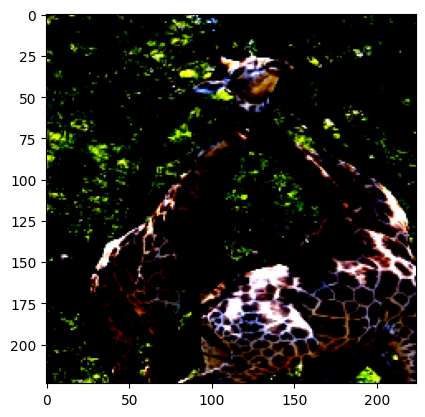

In [ ]:
img, target = coco_train[10]
plt.imshow(img.numpy().transpose(1,2,0));

### Define Dataset class

In [ ]:
class CocoDataset(Dataset):
    def __init__(self, num_objects,dataset):
        self.coco_dataset = dataset
        self.num_objects = num_objects

    def convert_to_one_hot(self,numbers, size):
        one_hot_vector = np.zeros(size)
        one_hot_vector[numbers] = 1
        return torch.from_numpy(one_hot_vector)

    def __getitem__(self, index):
        """
        target  >>   a 90d multi-hot vector  [obj1 ,obj2, ... , obj90]
        obj1 = 1,  it means there is object 1 in the image.
        obj1 = 1,  it means there is not object 1 in the image.
        """
        data,target = self.coco_dataset[index]
        objects_list = [target[i]['category_id']-1 for i in range(len(target))]
        # print(objects_list)
        return data , self.convert_to_one_hot(objects_list,self.num_objects)

    def __len__(self):
        return len(self.coco_dataset)

In [ ]:
# define train dataset
train_dataset = CocoDataset(90,coco_train)

# define train dataset(2)
train_dataset2 = CocoDataset(90,coco_train_2)

# define test dataset
test_dataset = CocoDataset(90,coco_val)

b_size = 64
# Create a data loader
train_data_loader = DataLoader(train_dataset, batch_size=b_size, shuffle=True)
train_data_loader2 = DataLoader(train_dataset2, batch_size=b_size, shuffle=True)

test_data_loader = DataLoader(test_dataset, batch_size=b_size, shuffle=True)

  0%|          | 0/160 [00:00<?, ?it/s]


tensor([0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=torch.float64)


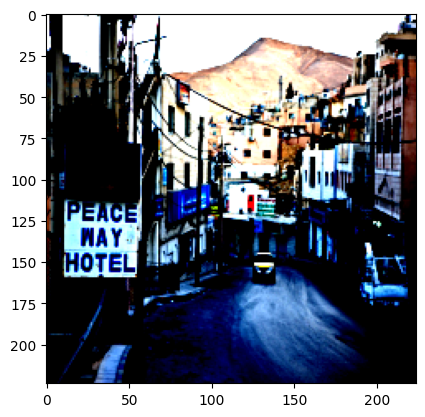

In [ ]:
for (data, targets) in tqdm(train_data_loader):
    index = 0
    plt.imshow(data[0].numpy().transpose(1, 2, 0))
    print(targets[0])
    break

## Define **Deformable Convolution** layer class

In [ ]:
class DeformableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels,kernel_size=3, stride=1, padding=1, dilation=1,deformable_groups=1):
        super(DeformableConv2d, self).__init__()

        self.kernel_size = (kernel_size, kernel_size)
        self.stride = (stride, stride)
        self.padding = padding
        self.dilation = dilation


        self.modulator = nn.Conv2d(in_channels,deformable_groups,
            kernel_size=self.kernel_size, stride=stride, padding=self.padding,
            dilation=self.dilation, bias=False)

        self.offset_conv = nn.Conv2d(in_channels,deformable_groups * 2,
            kernel_size=self.kernel_size, stride=stride, padding=self.padding,
            dilation=self.dilation, bias=False)

        self.final_conv = nn.Conv2d(in_channels,out_channels,
            kernel_size=self.kernel_size, stride=stride, padding=self.padding,
            dilation=self.dilation, bias=False)

    def deformed_feature(self, x):
        N, C, H, W = x.shape
        grid_y, grid_x = torch.meshgrid(torch.arange(H), torch.arange(W))
        grid_y = grid_y.to(device=x.device)
        grid_x = grid_x.to(device=x.device)
        # create offset
        offset = self.offset_conv(x)
        grid_y = grid_y.view(1, H, W) + offset[:, 0, :, :]  # y0 = y0 + Δy
        grid_x = grid_x.view(1, H, W) + offset[:, 1, :, :]  # x0 = x0 + Δx

        grid_y = 2 * grid_y / (H - 1) - 1
        grid_x = 2 * grid_x / (W - 1) - 1
        # Interpolate features
        grid = torch.stack((grid_x, grid_y), dim=-1)
        features = nn.functional.grid_sample(x, grid, mode='bilinear', align_corners=False)
        # create mask
        mask = 2 * torch.sigmoid(self.modulator(x))

        return features * mask

    def forward(self, x):
        deformed_features = self.deformed_feature(x)
        features = self.final_conv(deformed_features)
        return features

### Test the `DofromConv2d` layer:

In [ ]:
deformable_conv = DeformableConv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1, deformable_groups=1)
test = torch.randn(6, 32, 224, 224)  # (#samples, #in channels, # heights, # width)
out = deformable_conv(test)

print(out.shape)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([6, 64, 224, 224])


----

----

## Implement **ObjectDetector** class

In [ ]:
class ObjectDetector(nn.Module):
    def __init__(self, n_class, deformable=False):
        super().__init__()
        conv = nn.Conv2d if deformable==False else DeformableConv2d
        '''
        Each blockو consists of two convolutional layers followed
        by a max-pooling layer, with the exception of the last block which does not
        include a max-pooling layer.
        '''
        # input: 224x224x3"
        self.e11 = conv(3, 64, kernel_size=3, padding=1)
        self.e12 = conv(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e21 = conv(64, 128, kernel_size=3, padding=1)
        self.e22 = conv(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e31 = conv(128, 256, kernel_size=3, padding=1)
        self.e32 = conv(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e41 = conv(256, 512, kernel_size=3, padding=1)
        self.e42 = conv(512, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e51 = conv(512, 1024, kernel_size=3, padding=1)
        self.e52 = conv(1024, 1024, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(1024, n_class, kernel_size=1)

        self.fc_layers = nn.Sequential(
            nn.Linear(17640, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, n_class))

        self.BN = nn.BatchNorm1d(n_class)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Conv layers
        xe11 = relu(self.e11(x))
        xe12 = relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = relu(self.e21(xp1))
        xe22 = relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = relu(self.e31(xp2))
        xe32 = relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = relu(self.e41(xp3))
        xe42 = relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = relu(self.e51(xp4))
        xe52 = relu(self.e52(xe51))

        # Output layer
        out = self.outconv(xe52)
        out = self.fc_layers(out.view(out.shape[0],-1))
        out= self.BN(out)

        return self.sigmoid(out)

In [ ]:
def get_data_loaders(train_data_loader, test_data_loader):
    dataloaders = {
        'train': train_data_loader,
        'val': test_data_loader}
    return dataloaders

def calc_loss(pred, target,metrics, criterion):
    loss = criterion(pred, target)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    # print(loss.data.cpu().numpy(),'ppp')
    return loss

def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
    print("{}: {}".format(phase, ", ".join(outputs)))

In [ ]:
def train_model(model, optimizer, scheduler, num_epochs=20):
    output_metrics = {'f1':{'train':[],
                            'val':[]},
                      'precision':{'train':[],
                                    'val':[]},
                      'recall':{'train':[],
                                'val':[]},
                      'loss':{'train':[],
                              'val':[]}
                      }

    all_metrics = ['precision','recall','f1','loss']


    dataloaders = get_data_loaders(train_data_loader,test_data_loader)  # (train_data_loader2,test_data_loader)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    epoch_loss = 0
    losses = []
    criterion = torch.nn.BCELoss()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 20)

        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])

                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0

            all_predicted = []
            all_targets = []
            for index,(inputs, labels) in enumerate(tqdm(dataloaders[phase])):
                inputs = inputs.to(device).float()
                labels = labels.to(device).float()

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics, criterion)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                predicted = (outputs > 0.5).float()
                all_predicted.extend(predicted.cpu().numpy().flatten())
                all_targets.extend(labels.cpu().numpy().flatten())

                epoch_samples += inputs.size(0)

            temp = [0,0,0,0]
            temp[0], temp[1], temp[2], _ = precision_recall_fscore_support(all_targets, all_predicted, average='binary')
            temp[3] = metrics['loss'] / epoch_samples
            for index,metric in enumerate(all_metrics):
              output_metrics[metric][phase].append(temp[index])

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

        # save the checkpoint
        checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        }
        torch.save(checkpoint, f'/content/drive/My Drive/DEEP/HW3/Q2/checkpoints/model_checkpoint{epoch}.pth')

        # Save the dictionary to a file
        with open('/content/drive/My Drive/DEEP/dictionary_conv_deform.pickle', 'wb') as file:
            pickle.dump(output_metrics, file)

    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,output_metrics

## Train network with normal convolution:

In [ ]:
num_class = 90
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ObjectDetector(num_class).to(device)

optimizer_ft = torch.optim.Adam(model.parameters(), lr=1e-3)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=30, gamma=0.1)

ObjectDetector_model,output_metrics_cov = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=50)


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 0/49
--------------------
LR 0.001


100%|██████████| 160/160 [03:38<00:00,  1.36s/it]


train: loss: 0.657316


100%|██████████| 32/32 [00:26<00:00,  1.21it/s]


val: loss: 16.175447
saving best model
4m 6s
Epoch 1/49
--------------------
LR 0.001


100%|██████████| 160/160 [03:13<00:00,  1.21s/it]


train: loss: 0.590693


100%|██████████| 32/32 [00:23<00:00,  1.38it/s]


val: loss: 25.396586
3m 38s
Epoch 2/49
--------------------
LR 0.001


100%|██████████| 160/160 [03:11<00:00,  1.20s/it]


train: loss: 0.532483


100%|██████████| 32/32 [00:22<00:00,  1.45it/s]


val: loss: 19.690873
3m 35s
Epoch 3/49
--------------------
LR 0.001


100%|██████████| 160/160 [03:13<00:00,  1.21s/it]


train: loss: 0.481964


100%|██████████| 32/32 [00:23<00:00,  1.37it/s]


val: loss: 49.777411
3m 39s
Epoch 4/49
--------------------
LR 0.001


100%|██████████| 160/160 [03:12<00:00,  1.20s/it]


train: loss: 0.438042


100%|██████████| 32/32 [00:23<00:00,  1.39it/s]


val: loss: 0.446320
saving best model
3m 37s
Epoch 5/49
--------------------
LR 0.001


100%|██████████| 160/160 [03:10<00:00,  1.19s/it]


train: loss: 0.399587


100%|██████████| 32/32 [00:23<00:00,  1.38it/s]


val: loss: 0.380615
saving best model
3m 35s
Epoch 6/49
--------------------
LR 0.001


100%|██████████| 160/160 [03:11<00:00,  1.20s/it]


train: loss: 0.366015


100%|██████████| 32/32 [00:22<00:00,  1.40it/s]


val: loss: 0.356751
saving best model
3m 36s
Epoch 7/49
--------------------
LR 0.001


100%|██████████| 160/160 [03:08<00:00,  1.18s/it]


train: loss: 0.336725


100%|██████████| 32/32 [00:22<00:00,  1.42it/s]


val: loss: 0.329867
saving best model
3m 33s
Epoch 8/49
--------------------
LR 0.001


100%|██████████| 160/160 [03:09<00:00,  1.18s/it]


train: loss: 0.311145


100%|██████████| 32/32 [00:21<00:00,  1.46it/s]


val: loss: 0.328015
saving best model
3m 33s
Epoch 9/49
--------------------
LR 0.001


100%|██████████| 160/160 [03:09<00:00,  1.18s/it]


train: loss: 0.288774


100%|██████████| 32/32 [00:22<00:00,  1.43it/s]


val: loss: 0.304678
saving best model
3m 33s
Epoch 10/49
--------------------
LR 0.001


100%|██████████| 160/160 [03:12<00:00,  1.21s/it]


train: loss: 0.269174


100%|██████████| 32/32 [00:22<00:00,  1.42it/s]


val: loss: 0.303933
saving best model
3m 37s
Epoch 11/49
--------------------
LR 0.001


100%|██████████| 160/160 [03:11<00:00,  1.20s/it]


train: loss: 0.251976


100%|██████████| 32/32 [00:23<00:00,  1.39it/s]


val: loss: 0.293869
saving best model
3m 36s
Epoch 12/49
--------------------
LR 0.001


100%|██████████| 160/160 [03:10<00:00,  1.19s/it]


train: loss: 0.236857


100%|██████████| 32/32 [00:23<00:00,  1.37it/s]


val: loss: 0.231573
saving best model
3m 35s
Epoch 13/49
--------------------
LR 0.001


100%|██████████| 160/160 [03:11<00:00,  1.20s/it]


train: loss: 0.223544


100%|██████████| 32/32 [00:22<00:00,  1.39it/s]


val: loss: 0.216816
saving best model
3m 36s
Epoch 14/49
--------------------
LR 0.001


100%|██████████| 160/160 [03:09<00:00,  1.18s/it]


train: loss: 0.211801


100%|██████████| 32/32 [00:23<00:00,  1.39it/s]


val: loss: 0.203181
saving best model
3m 34s
Epoch 15/49
--------------------
LR 0.001


100%|██████████| 160/160 [03:08<00:00,  1.18s/it]


train: loss: 0.201427


100%|██████████| 32/32 [00:23<00:00,  1.39it/s]


val: loss: 0.201776
saving best model
3m 33s
Epoch 16/49
--------------------
LR 0.001


100%|██████████| 160/160 [03:10<00:00,  1.19s/it]


train: loss: 0.192247


100%|██████████| 32/32 [00:23<00:00,  1.39it/s]


val: loss: 0.189649
saving best model
3m 35s
Epoch 17/49
--------------------
LR 0.001


100%|██████████| 160/160 [03:10<00:00,  1.19s/it]


train: loss: 0.184115


100%|██████████| 32/32 [00:23<00:00,  1.38it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


val: loss: 0.201379
3m 35s
Epoch 18/49
--------------------
LR 0.001


100%|██████████| 160/160 [03:10<00:00,  1.19s/it]


train: loss: 0.176900


100%|██████████| 32/32 [00:22<00:00,  1.41it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


val: loss: 0.194080
3m 35s
Epoch 19/49
--------------------
LR 0.001


100%|██████████| 160/160 [03:09<00:00,  1.18s/it]


train: loss: 0.170494


100%|██████████| 32/32 [00:22<00:00,  1.43it/s]


val: loss: 0.189408
saving best model
3m 34s
Epoch 20/49
--------------------
LR 0.001


100%|██████████| 160/160 [03:09<00:00,  1.19s/it]


train: loss: 0.164800


100%|██████████| 32/32 [00:22<00:00,  1.45it/s]


val: loss: 0.181133
saving best model
3m 34s
Epoch 21/49
--------------------
LR 0.001


100%|██████████| 160/160 [03:11<00:00,  1.19s/it]


train: loss: 0.159735


100%|██████████| 32/32 [00:22<00:00,  1.41it/s]


val: loss: 0.167133
saving best model
3m 36s
Epoch 22/49
--------------------
LR 0.001


100%|██████████| 160/160 [03:09<00:00,  1.19s/it]


train: loss: 0.155228


100%|██████████| 32/32 [00:22<00:00,  1.43it/s]


val: loss: 0.160160
saving best model
3m 34s
Epoch 23/49
--------------------
LR 0.001


100%|██████████| 160/160 [03:11<00:00,  1.20s/it]


train: loss: 0.151216


100%|██████████| 32/32 [00:22<00:00,  1.44it/s]


val: loss: 0.154250
saving best model
3m 35s
Epoch 24/49
--------------------
LR 0.001


100%|██████████| 160/160 [03:10<00:00,  1.19s/it]


train: loss: 0.147643


100%|██████████| 32/32 [00:21<00:00,  1.47it/s]


val: loss: 0.153555
saving best model
3m 34s
Epoch 25/49
--------------------
LR 0.001


100%|██████████| 160/160 [03:10<00:00,  1.19s/it]


train: loss: 0.144460


100%|██████████| 32/32 [00:22<00:00,  1.44it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


val: loss: 0.147962
saving best model
3m 34s
Epoch 26/49
--------------------
LR 0.001


100%|██████████| 160/160 [03:10<00:00,  1.19s/it]


train: loss: 0.141627


100%|██████████| 32/32 [00:22<00:00,  1.41it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


val: loss: 0.147830
saving best model
3m 35s
Epoch 27/49
--------------------
LR 0.001


100%|██████████| 160/160 [03:10<00:00,  1.19s/it]


train: loss: 0.139104


100%|██████████| 32/32 [00:23<00:00,  1.39it/s]


val: loss: 0.144138
saving best model
3m 35s
Epoch 28/49
--------------------
LR 0.001


100%|██████████| 160/160 [03:10<00:00,  1.19s/it]


train: loss: 0.136858


100%|██████████| 32/32 [00:22<00:00,  1.40it/s]


val: loss: 0.141502
saving best model
3m 35s
Epoch 29/49
--------------------
LR 0.0001


100%|██████████| 160/160 [03:09<00:00,  1.18s/it]


train: loss: 0.135713


100%|██████████| 32/32 [00:22<00:00,  1.39it/s]


val: loss: 0.138310
saving best model
3m 33s
Epoch 30/49
--------------------
LR 0.0001


100%|██████████| 160/160 [03:10<00:00,  1.19s/it]


train: loss: 0.135505


100%|██████████| 32/32 [00:22<00:00,  1.42it/s]


val: loss: 0.137954
saving best model
3m 35s
Epoch 31/49
--------------------
LR 0.0001


100%|██████████| 160/160 [03:11<00:00,  1.20s/it]


train: loss: 0.135289


100%|██████████| 32/32 [00:22<00:00,  1.43it/s]


val: loss: 0.137804
saving best model
3m 35s
Epoch 32/49
--------------------
LR 0.0001


100%|██████████| 160/160 [03:10<00:00,  1.19s/it]


train: loss: 0.135063


100%|██████████| 32/32 [00:22<00:00,  1.41it/s]


val: loss: 0.137736
saving best model
3m 35s
Epoch 33/49
--------------------
LR 0.0001


100%|██████████| 160/160 [03:10<00:00,  1.19s/it]


train: loss: 0.134830


100%|██████████| 32/32 [00:22<00:00,  1.39it/s]


val: loss: 0.137296
saving best model
3m 35s
Epoch 34/49
--------------------
LR 0.0001


100%|██████████| 160/160 [03:10<00:00,  1.19s/it]


train: loss: 0.134589


100%|██████████| 32/32 [00:22<00:00,  1.41it/s]


val: loss: 0.137120
saving best model
3m 34s
Epoch 35/49
--------------------
LR 0.0001


100%|██████████| 160/160 [03:10<00:00,  1.19s/it]


train: loss: 0.134341


100%|██████████| 32/32 [00:23<00:00,  1.39it/s]


val: loss: 0.136786
saving best model
3m 35s
Epoch 36/49
--------------------
LR 0.0001


100%|██████████| 160/160 [03:11<00:00,  1.20s/it]


train: loss: 0.134087


100%|██████████| 32/32 [00:21<00:00,  1.46it/s]


val: loss: 0.136587
saving best model
3m 35s
Epoch 37/49
--------------------
LR 0.0001


100%|██████████| 160/160 [03:11<00:00,  1.20s/it]


train: loss: 0.133827


100%|██████████| 32/32 [00:23<00:00,  1.37it/s]


val: loss: 0.136147
saving best model
3m 36s
Epoch 38/49
--------------------
LR 0.0001


100%|██████████| 160/160 [03:10<00:00,  1.19s/it]


train: loss: 0.133563


100%|██████████| 32/32 [00:23<00:00,  1.34it/s]


val: loss: 0.136098
saving best model
3m 36s
Epoch 39/49
--------------------
LR 0.0001


100%|██████████| 160/160 [03:12<00:00,  1.21s/it]


train: loss: 0.133295


100%|██████████| 32/32 [00:22<00:00,  1.42it/s]


val: loss: 0.135793
saving best model
3m 37s
Epoch 40/49
--------------------
LR 0.0001


100%|██████████| 160/160 [03:10<00:00,  1.19s/it]


train: loss: 0.133023


100%|██████████| 32/32 [00:22<00:00,  1.39it/s]


val: loss: 0.135579
saving best model
3m 35s
Epoch 41/49
--------------------
LR 0.0001


100%|██████████| 160/160 [03:11<00:00,  1.20s/it]


train: loss: 0.132750


100%|██████████| 32/32 [00:23<00:00,  1.38it/s]


val: loss: 0.135310
saving best model
3m 36s
Epoch 42/49
--------------------
LR 0.0001


100%|██████████| 160/160 [03:13<00:00,  1.21s/it]


train: loss: 0.132475


100%|██████████| 32/32 [00:22<00:00,  1.40it/s]


val: loss: 0.134949
saving best model
3m 37s
Epoch 43/49
--------------------
LR 0.0001


100%|██████████| 160/160 [03:11<00:00,  1.20s/it]


train: loss: 0.132199


100%|██████████| 32/32 [00:22<00:00,  1.40it/s]


val: loss: 0.134540
saving best model
3m 36s
Epoch 44/49
--------------------
LR 0.0001


100%|██████████| 160/160 [03:11<00:00,  1.20s/it]


train: loss: 0.131924


100%|██████████| 32/32 [00:24<00:00,  1.32it/s]


val: loss: 0.134337
saving best model
3m 37s
Epoch 45/49
--------------------
LR 0.0001


100%|██████████| 160/160 [03:11<00:00,  1.20s/it]


train: loss: 0.131649


100%|██████████| 32/32 [00:22<00:00,  1.40it/s]


val: loss: 0.134081
saving best model
3m 36s
Epoch 46/49
--------------------
LR 0.0001


100%|██████████| 160/160 [03:11<00:00,  1.20s/it]


train: loss: 0.131376


100%|██████████| 32/32 [00:22<00:00,  1.40it/s]


val: loss: 0.133863
saving best model
3m 36s
Epoch 47/49
--------------------
LR 0.0001


100%|██████████| 160/160 [03:12<00:00,  1.20s/it]


train: loss: 0.131105


100%|██████████| 32/32 [00:22<00:00,  1.39it/s]


val: loss: 0.133606
saving best model
3m 36s
Epoch 48/49
--------------------
LR 0.0001


100%|██████████| 160/160 [03:15<00:00,  1.22s/it]


train: loss: 0.130837


100%|██████████| 32/32 [00:23<00:00,  1.35it/s]


val: loss: 0.133305
saving best model
3m 40s
Epoch 49/49
--------------------
LR 0.0001


100%|██████████| 160/160 [03:16<00:00,  1.23s/it]


train: loss: 0.130571


100%|██████████| 32/32 [00:22<00:00,  1.43it/s]


val: loss: 0.133012
saving best model
3m 41s
Best val loss: 0.133012


## Train network with deformable convolution:

in the `Question2_2.ipynb`

In [ ]:
# load metrices

with open('/content/drive/My Drive/DEEP/dictionary_conv_deform.pickle', 'rb') as file:
    output_metrics_deform_cov = pickle.load(file)

with open('/content/drive/My Drive/DEEP/dictionary_conv_@.pickle', 'rb') as file:
    output_metrics_cov = pickle.load(file)


## Compaire results

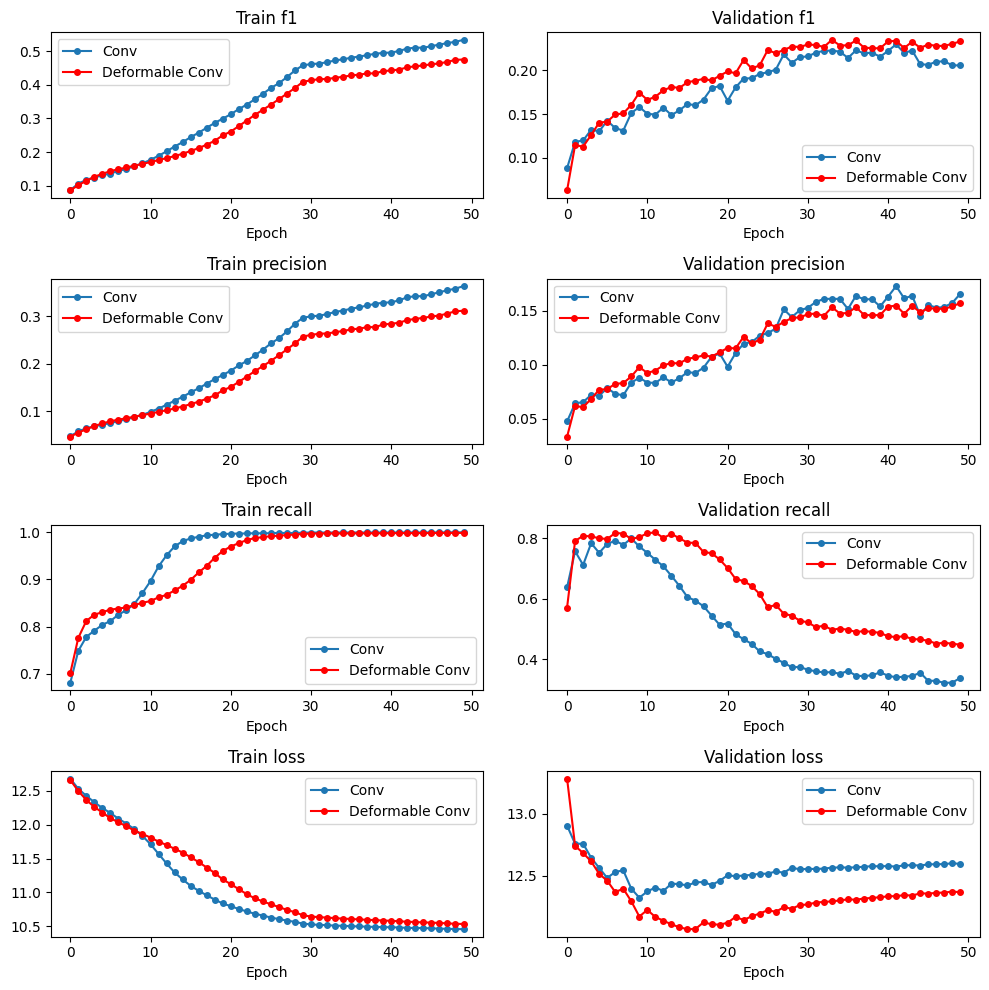

In [ ]:
compaire_results(output_metrics_deform_cov,output_metrics_cov)

In [ ]:
# !pip install numba

# from numba import cuda
# device = cuda.get_current_device()
# device.reset()
# torch.cuda.empty_cache()

In [ ]:
class ObjectDetector2(nn.Module):
    def __init__(self, n_class, deformable=False):
        super().__init__()
        conv = nn.Conv2d #if deformable==False else DeformableConv2d
        conv1 = nn.Conv2d if deformable==False else DeformableConv2d
        '''
        Each blockو consists of two convolutional layers followed
        by a max-pooling layer, with the exception of the last block which does not
        include a max-pooling layer.
        '''
        # input: 224x224x3"
        self.e11 = conv1(3, 64, kernel_size=3, padding=1)
        self.e12 = conv1(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e21 = conv(64, 128, kernel_size=3, padding=1)
        self.e22 = conv(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e31 = conv(128, 256, kernel_size=3, padding=1)
        self.e32 = conv(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e41 = conv(256, 512, kernel_size=3, padding=1)
        self.e42 = conv(512, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e51 = conv(512, 1024, kernel_size=3, padding=1)
        self.e52 = conv(1024, 1024, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(1024, n_class, kernel_size=1)

        self.fc_layers = nn.Sequential(
            nn.Linear(17640, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, n_class))

        self.BN = nn.BatchNorm1d(n_class)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Conv layers
        xe11 = relu(self.e11(x))
        xe12 = relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = relu(self.e21(xp1))
        xe22 = relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = relu(self.e31(xp2))
        xe32 = relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = relu(self.e41(xp3))
        xe42 = relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = relu(self.e51(xp4))
        xe52 = relu(self.e52(xe51))

        # Output layer
        out = self.outconv(xe52)
        out = self.fc_layers(out.view(out.shape[0],-1))
        out= self.BN(out)

        return self.sigmoid(out)

## Train network with normal convolution:

In [ ]:
num_class = 90
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ObjectDetector2(num_class).to(device)

optimizer_ft = torch.optim.Adam(model.parameters(), lr=1e-3)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=30, gamma=0.1)

ObjectDetector_model,output_metrics_cov = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=20)


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 0/19
--------------------
LR 0.001


100%|██████████| 160/160 [03:39<00:00,  1.37s/it]


train: loss: 0.657123


100%|██████████| 32/32 [00:30<00:00,  1.04it/s]


val: loss: 38.973631
saving best model
4m 12s
Epoch 1/19
--------------------
LR 0.001


100%|██████████| 160/160 [03:16<00:00,  1.23s/it]


train: loss: 0.590990


100%|██████████| 32/32 [00:22<00:00,  1.40it/s]


val: loss: 37.229615
saving best model
3m 40s
Epoch 2/19
--------------------
LR 0.001


100%|██████████| 160/160 [03:15<00:00,  1.22s/it]


train: loss: 0.532689


100%|██████████| 32/32 [00:23<00:00,  1.35it/s]


val: loss: 44.153602
3m 41s
Epoch 3/19
--------------------
LR 0.001


100%|██████████| 160/160 [03:15<00:00,  1.22s/it]


train: loss: 0.481641


100%|██████████| 32/32 [00:23<00:00,  1.38it/s]


val: loss: 36.048639
saving best model
3m 41s
Epoch 4/19
--------------------
LR 0.001


100%|██████████| 160/160 [03:15<00:00,  1.22s/it]


train: loss: 0.437048


100%|██████████| 32/32 [00:22<00:00,  1.45it/s]


val: loss: 35.411097
saving best model
3m 38s
Epoch 5/19
--------------------
LR 0.001


100%|██████████| 160/160 [03:15<00:00,  1.22s/it]


train: loss: 0.398075


100%|██████████| 32/32 [00:22<00:00,  1.39it/s]


val: loss: 31.663440
saving best model
3m 40s
Epoch 6/19
--------------------
LR 0.001


100%|██████████| 160/160 [03:14<00:00,  1.22s/it]


train: loss: 0.364150


100%|██████████| 32/32 [00:23<00:00,  1.34it/s]


val: loss: 30.609178
saving best model
3m 40s
Epoch 7/19
--------------------
LR 0.001


100%|██████████| 160/160 [03:16<00:00,  1.23s/it]


train: loss: 0.334915


100%|██████████| 32/32 [00:24<00:00,  1.31it/s]


val: loss: 49.562881
3m 43s
Epoch 8/19
--------------------
LR 0.001


100%|██████████| 160/160 [03:14<00:00,  1.22s/it]


train: loss: 0.309289


100%|██████████| 32/32 [00:23<00:00,  1.35it/s]


val: loss: 29.901360
saving best model
3m 39s
Epoch 9/19
--------------------
LR 0.001


100%|██████████| 160/160 [03:14<00:00,  1.21s/it]


train: loss: 0.287435


100%|██████████| 32/32 [00:22<00:00,  1.42it/s]


val: loss: 47.073039
3m 39s
Epoch 10/19
--------------------
LR 0.001


100%|██████████| 160/160 [03:12<00:00,  1.20s/it]


train: loss: 0.269055


100%|██████████| 32/32 [00:21<00:00,  1.46it/s]


val: loss: 1.017998
saving best model
3m 36s
Epoch 11/19
--------------------
LR 0.001


100%|██████████| 160/160 [03:13<00:00,  1.21s/it]


train: loss: 0.251890


100%|██████████| 32/32 [00:26<00:00,  1.20it/s]


val: loss: 1.450876
3m 42s
Epoch 12/19
--------------------
LR 0.001


100%|██████████| 160/160 [03:17<00:00,  1.23s/it]


train: loss: 0.236846


100%|██████████| 32/32 [00:23<00:00,  1.34it/s]


val: loss: 26.221733
3m 43s
Epoch 13/19
--------------------
LR 0.001


100%|██████████| 160/160 [03:16<00:00,  1.23s/it]


train: loss: 0.223490


100%|██████████| 32/32 [00:22<00:00,  1.44it/s]


val: loss: 2.706173
3m 40s
Epoch 14/19
--------------------
LR 0.001


100%|██████████| 160/160 [03:15<00:00,  1.22s/it]


train: loss: 0.211762


100%|██████████| 32/32 [00:25<00:00,  1.27it/s]


val: loss: 1.784043
3m 42s
Epoch 15/19
--------------------
LR 0.001


100%|██████████| 160/160 [03:13<00:00,  1.21s/it]


train: loss: 0.201398


100%|██████████| 32/32 [00:23<00:00,  1.36it/s]


val: loss: 5.274540
3m 38s
Epoch 16/19
--------------------
LR 0.001


100%|██████████| 160/160 [03:14<00:00,  1.22s/it]


train: loss: 0.192228


100%|██████████| 32/32 [00:23<00:00,  1.35it/s]


val: loss: 3.965104
3m 39s
Epoch 17/19
--------------------
LR 0.001


100%|██████████| 160/160 [03:12<00:00,  1.20s/it]


train: loss: 0.184100


100%|██████████| 32/32 [00:22<00:00,  1.39it/s]


val: loss: 18.358304
3m 38s
Epoch 18/19
--------------------
LR 0.001


100%|██████████| 160/160 [03:13<00:00,  1.21s/it]


train: loss: 0.176891


100%|██████████| 32/32 [00:23<00:00,  1.38it/s]


val: loss: 23.701922
3m 39s
Epoch 19/19
--------------------
LR 0.001


100%|██████████| 160/160 [03:13<00:00,  1.21s/it]


train: loss: 0.170489


100%|██████████| 32/32 [00:22<00:00,  1.44it/s]


val: loss: 46.818214
3m 37s
Best val loss: 1.017998


## Train network with deformable convolution:

In [ ]:
num_class = 90
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ObjectDetector2(num_class,True).to(device)

optimizer_ft = torch.optim.Adam(model.parameters(), lr=1e-3)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=30, gamma=0.1)

ObjectDetector_model_deform,output_metrics_deform_cov = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=20)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 0/19
--------------------
LR 0.001


100%|██████████| 160/160 [08:19<00:00,  3.12s/it]


train: loss: 0.658483


100%|██████████| 32/32 [00:36<00:00,  1.14s/it]


val: loss: 26.300731
saving best model
8m 57s
Epoch 1/19
--------------------
LR 0.001


100%|██████████| 160/160 [08:01<00:00,  3.01s/it]


train: loss: 0.590797


100%|██████████| 32/32 [00:33<00:00,  1.05s/it]


val: loss: 28.473280
8m 37s
Epoch 2/19
--------------------
LR 0.001


100%|██████████| 160/160 [07:56<00:00,  2.98s/it]


train: loss: 0.532953


100%|██████████| 32/32 [00:32<00:00,  1.03s/it]


val: loss: 45.191129
8m 32s
Epoch 3/19
--------------------
LR 0.001


100%|██████████| 160/160 [07:50<00:00,  2.94s/it]


train: loss: 0.482329


100%|██████████| 32/32 [00:33<00:00,  1.06s/it]


val: loss: 34.257705
8m 26s
Epoch 4/19
--------------------
LR 0.001


100%|██████████| 160/160 [07:51<00:00,  2.95s/it]


train: loss: 0.438074


100%|██████████| 32/32 [00:32<00:00,  1.01s/it]


val: loss: 31.526224
8m 26s
Epoch 5/19
--------------------
LR 0.001


100%|██████████| 160/160 [07:51<00:00,  2.95s/it]


train: loss: 0.399542


100%|██████████| 32/32 [00:32<00:00,  1.02s/it]


val: loss: 34.529446
8m 25s
Epoch 6/19
--------------------
LR 0.001


100%|██████████| 160/160 [07:47<00:00,  2.92s/it]


train: loss: 0.365972


100%|██████████| 32/32 [00:33<00:00,  1.03s/it]


val: loss: 0.344876
saving best model
8m 22s
Epoch 7/19
--------------------
LR 0.001


100%|██████████| 160/160 [07:45<00:00,  2.91s/it]


train: loss: 0.336726


100%|██████████| 32/32 [00:33<00:00,  1.05s/it]


val: loss: 0.327520
saving best model
8m 21s
Epoch 8/19
--------------------
LR 0.001


100%|██████████| 160/160 [07:46<00:00,  2.92s/it]


train: loss: 0.311145


100%|██████████| 32/32 [00:32<00:00,  1.01s/it]


val: loss: 0.315616
saving best model
8m 21s
Epoch 9/19
--------------------
LR 0.001


100%|██████████| 160/160 [07:44<00:00,  2.90s/it]


train: loss: 0.288770


100%|██████████| 32/32 [00:34<00:00,  1.07s/it]


val: loss: 0.299563
saving best model
8m 19s
Epoch 10/19
--------------------
LR 0.001


100%|██████████| 160/160 [07:44<00:00,  2.90s/it]


train: loss: 0.269171


100%|██████████| 32/32 [00:34<00:00,  1.07s/it]


val: loss: 0.295380
saving best model
8m 20s
Epoch 11/19
--------------------
LR 0.001


100%|██████████| 160/160 [07:42<00:00,  2.89s/it]


train: loss: 0.251974


100%|██████████| 32/32 [00:32<00:00,  1.02s/it]


val: loss: 0.276224
saving best model
8m 17s
Epoch 12/19
--------------------
LR 0.001


100%|██████████| 160/160 [07:49<00:00,  2.94s/it]


train: loss: 0.236857


100%|██████████| 32/32 [00:32<00:00,  1.02s/it]


val: loss: 0.220773
saving best model
8m 24s
Epoch 13/19
--------------------
LR 0.001


100%|██████████| 160/160 [07:47<00:00,  2.92s/it]


train: loss: 0.223545


100%|██████████| 32/32 [00:33<00:00,  1.03s/it]


val: loss: 0.212729
saving best model
8m 22s
Epoch 14/19
--------------------
LR 0.001


100%|██████████| 160/160 [07:47<00:00,  2.92s/it]


train: loss: 0.211801


100%|██████████| 32/32 [00:32<00:00,  1.02s/it]


val: loss: 0.209943
saving best model
8m 22s
Epoch 15/19
--------------------
LR 0.001


100%|██████████| 160/160 [07:42<00:00,  2.89s/it]


train: loss: 0.201425


100%|██████████| 32/32 [00:32<00:00,  1.00s/it]


val: loss: 0.200893
saving best model
8m 16s
Epoch 16/19
--------------------
LR 0.001


100%|██████████| 160/160 [07:42<00:00,  2.89s/it]


train: loss: 0.192246


100%|██████████| 32/32 [00:33<00:00,  1.04s/it]


val: loss: 0.191902
saving best model
8m 18s
Epoch 17/19
--------------------
LR 0.001


100%|██████████| 160/160 [07:43<00:00,  2.90s/it]


train: loss: 0.184112


100%|██████████| 32/32 [00:33<00:00,  1.04s/it]


val: loss: 0.200944
8m 19s
Epoch 18/19
--------------------
LR 0.001


100%|██████████| 160/160 [07:43<00:00,  2.89s/it]


train: loss: 0.176897


100%|██████████| 32/32 [00:33<00:00,  1.05s/it]


val: loss: 0.196011
8m 19s
Epoch 19/19
--------------------
LR 0.001


100%|██████████| 160/160 [07:43<00:00,  2.90s/it]


train: loss: 0.170491


100%|██████████| 32/32 [00:36<00:00,  1.13s/it]


val: loss: 0.193000
8m 22s
Best val loss: 0.191902


In [11]:
# load metrices

with open('/content/drive/My Drive/DEEP/dictionary_conv_deform.pickle', 'rb') as file:
    output_metrics_deform_cov = pickle.load(file)

with open('/content/drive/My Drive/DEEP/dictionary_conv_@.pickle', 'rb') as file:
    output_metrics_cov = pickle.load(file)


## Compaire results

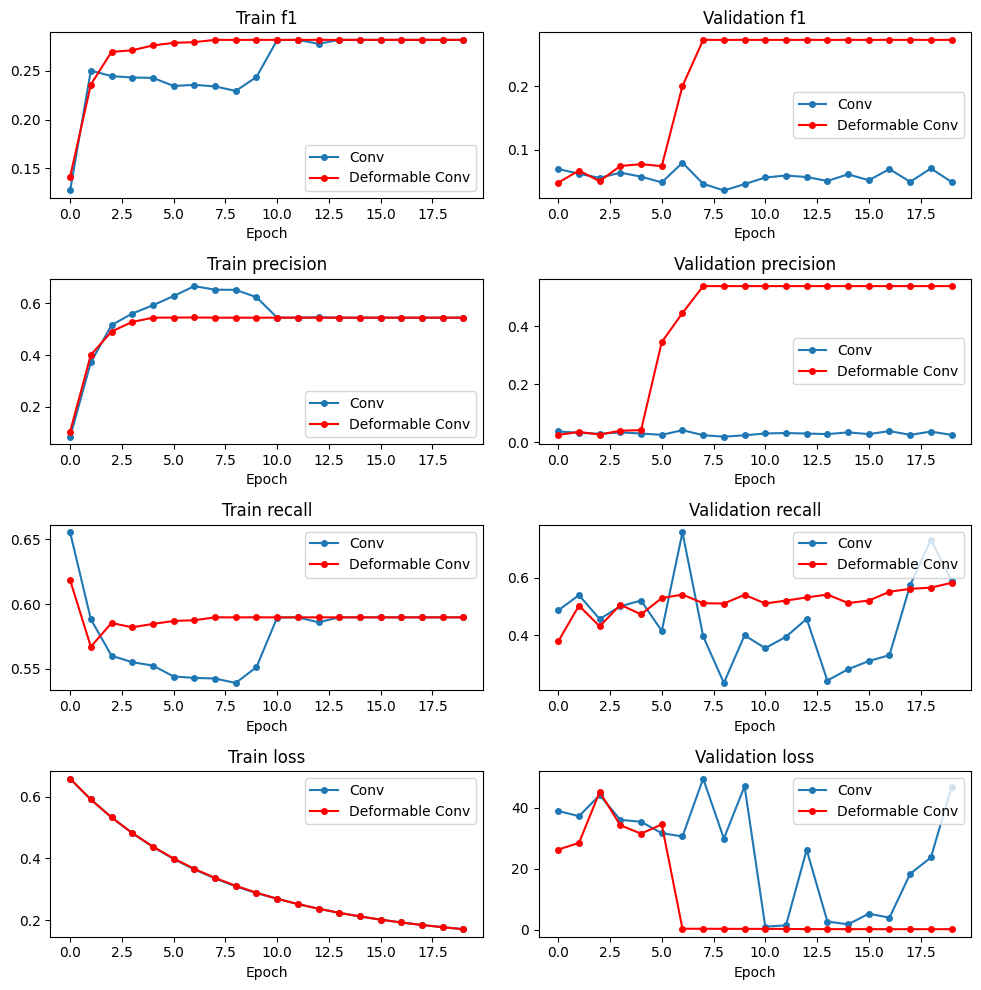

In [65]:
compaire_results(output_metrics_deform_cov,output_metrics_cov)

# **END :/**

----
----
----

# network 2

(**Not good enough**)

In [ ]:
class ObjectDetecotr(nn.Module):
    def __init__(self, num_classes,deformable=False):

        super(ObjectDetecotr, self).__init__()
        conv = nn.Conv2d if deformable==False else DeformableConv2d
        self.sigmoid = nn.Sigmoid()
        self.conv_layers = nn.Sequential(
            conv(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            conv(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            conv(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(50176, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        x = self.sigmoid(x)
        return x

In [ ]:
obj_detector = ObjectDetecotr(90).to(device)

In [ ]:
print('test the net!\n')

for (data, targets) in tqdm(train_data_loader):
    print('\n',obj_detector(data.to(device)).shape, targets.shape)
    break

test the net!



  0%|          | 0/925 [00:01<?, ?it/s]


 torch.Size([128, 90]) torch.Size([128, 90])


## Train network

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(obj_detector.parameters(), lr=0.01)

num_epochs = 30

losses = []
accuracies = []

for _epoch in range(num_epochs):
    epoch_loss = 0
    train_acc = 0
    for (data, targets) in tqdm(train_data_loader):
        optimizer.zero_grad()

        # Forward pass
        outputs = obj_detector(data.to(device))

        # Calculate loss
        loss = criterion(outputs, targets.to(device))

        # Backward pass and optimization
        loss.backward()
        optimizer.step()


        # Save model checkpoint
        checkpoint = {
            'epoch': _epoch + 1,
            'model_state_dict': obj_detector.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
        }
        torch.save(checkpoint, f'/content/drive/My Drive/DEEP/HW3/Q3/model1/model_checkpoint{_epoch}.pth')

        epoch_loss += loss.item()

    print(f'loss @ epoch {_epoch+1}: {epoch_loss}')
    losses.append(epoch_loss)

    # print('train accuracy: ',(train_acc/len(train_data_loader))*100)
    # accuracies.append((train_acc/len(train_data_loader))*100)


100%|██████████| 925/925 [23:04<00:00,  1.50s/it]


loss @ epoch 1: 11615.999107652158


100%|██████████| 925/925 [21:59<00:00,  1.43s/it]


loss @ epoch 2: 11615.519074043259


100%|██████████| 925/925 [20:56<00:00,  1.36s/it]


loss @ epoch 3: 11610.633855321259


100%|██████████| 925/925 [20:49<00:00,  1.35s/it]


loss @ epoch 4: 11614.762331473703


  1%|          | 9/925 [00:11<20:12,  1.32s/it]


KeyboardInterrupt: ignored

Save the model :

In [ ]:
torch.save(obj_detector.state_dict(), '/content/drive/My Drive/DEEP/HW3/Q2/model1/q2_model1.pth')